## Import your stuff

In [1]:
import numpy as np
import pandas as pd
import emcee
from scipy.optimize import minimize
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import matplotlib as mpl
import simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 1

## Set up the prior

In [2]:
upper = np.array([50,  50, 50,  50, 50, 50, 50,50])
lower = np.array([-50,  -50, -50, -50, -50, -50, -50, -50])

prior_mean = np.array([0]*8 + [1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([15]*8+[(0.0011*0.2)**2, (0.39*0.2)**2]))

prior = priors.Gaussian(prior_mean, prior_cov)

epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.5] * 94))
epsilon_prior = priors.Gaussian(epsilon_mean, epsilon_cov)

#print(faasSimulator.exp(1))

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [3]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(th, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.draw()
    #eps.index = ['epsilon' + str(i) for i in np.arange(0,94)]
    #eps = [0] * 94
    
    
    return faasSimulator.simulation(np.concatenate([th, eps]), seed)

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0

theta_f = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01]

# #th = [7.41182866e+00,  1.08261090e+01,  1.17609716e+01,  1.18367247e+01
#  -3.77631101e+00, -5.19751189e+00, -4.17913301e+00, -5.19552395e+00,
#   1.41581953e-03, -3.82868255e-01]
#print(simulator(theta_f, 0, simulator_args, 1))


In [ ]:
# theta_fiducial = np.array([8.886491e+00,  7.924279e+00,
#   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
#  -6.585027e+00,  1.100000e-03, -3.900000e-01])
# eta_fiducial = np.array(np.load('epsfid.npy'))

# Cinv = faasSimulator.Cinv
# #np.save('Finv.npy', Finv) # save Finv
# mu = np.load('mu.npy') # save mu
# #np.save('Cinv.npy', Cinv) # save Cinv
# dmudt = np.load('dmudt.npy') # save dmudt


# Compressor = score.Gaussian(len(faasSimulator.data()[0,:]), np.concatenate([theta_fiducial, eta_fiducial]), 
#                             mu = mu, Cinv = Cinv, dmudt = dmudt)

# Compressor.compute_fisher()
# Finv = Compressor.Finv[0:10,0:10]

# nuisance_indices = np.arange(10,104)

# def compressor(d, compressor_args):
#     nuisances_indices = compressor_args[0]
#     return Compressor.projected_scoreMLE(d, nuisance_indices)
# compressor_args = [nuisance_indices]

## Set up the compressor
This must have the signature `compressor(data, args)` -> `np.array([n_summaries])`
In this case we are going to do _nuisance hardened_ Gaussian score compression $$\bar{\mathbf{t}}_\theta = \mathbf{t}_\theta - \mathbf{F}_{\theta\eta}\mathbf{F}^{-1}_{\eta\eta}\mathbf{t}_\eta$$ where $$\mathbf{t}_{(\theta, \eta)} = \nabla_{(\theta, \eta)}^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$
We'll use the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
mu = np.load('mu.npy')
Cinv = np.load('Cinv.npy')
dmudt = np.load('dmudt.npy')
Finv = np.linalg.inv(np.load('Finv.npy'))

In [7]:
theta_fiducial = np.array([8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100000e-03, -3.900000e-01])
eta_fiducial = np.load('epsfid_faas.npy')
mu = faasSimulator.simulation(np.concatenate([theta_fiducial, eta_fiducial]), seed)
Cinv = faasSimulator.Cinv

h = np.array(abs(np.concatenate([theta_fiducial, eta_fiducial])))*0.01
dmudt = faasSimulator.dmudt(np.concatenate([theta_fiducial, eta_fiducial]), h)


Compressor = score.Gaussian(len(faasSimulator.data()[0,:]), np.concatenate([theta_fiducial, eta_fiducial]), 
                            mu = mu, Cinv = Cinv, dmudt = dmudt)

Compressor.compute_fisher()
Finv = Compressor.Finv
#Finv = Compressor.Finv[0:10,0:10]



nuisance_indices = np.arange(10,104)

def compressor(d, compressor_args):
    nuisances_indices = compressor_args[0]
    return Compressor.projected_scoreMLE(d, nuisance_indices)
compressor_args = [nuisance_indices]

In [8]:
np.save('Finv.npy', Finv)
np.save('dmudt.npy', dmudt)
np.save('mu.npy', mu)
np.save('Cinv.npy', Cinv)

## Load in the compressed data

In [9]:
compressed_data = compressor(faasSimulator.data_comp(), compressor_args)
print(compressed_data)
n_data = len(compressed_data)

[ 9.92434218e+00  7.65803501e+00  1.04432672e+01  7.65176394e+00
 -3.10519053e+00 -4.29501806e+00 -6.31968593e+00 -7.69318575e+00
  1.10366948e-03 -3.96936199e-01]


## Load in data

In [ ]:
# data = faasSimulator.data()[0]

## Define ensemble of NDEs

In [10]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=10, n_data=n_data, n_hiddens=[50,50], n_mades=10, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=6)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [11]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, Finv = None, theta_fiducial = theta_fiducial,
                       param_limits = [np.concatenate((lower, [(0.0011-(0.0011*0.8)**2),(-0.39-(0.39*0.8)**2)])), np.concatenate((upper, [(0.0011+(0.0011*0.8)**2),(-0.39+(0.39*0.8)**2)]))],
                       param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
                       results_dir = "results/",input_normalization = None, restore = False, save = True, nwalkers = 500)

In [ ]:
# DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
#                        param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
#                        results_dir = "results_batch_whole_comp/", restore = False, save = True)

## Fisher pre-training to initialize the NDEs

In [ ]:
#DelfiEnsemble.fisher_pretraining(plot=False)

## Sequential Neural Likelihood

/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Population 1/15
Sampling proposal density...
Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:87: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_first = first - peak


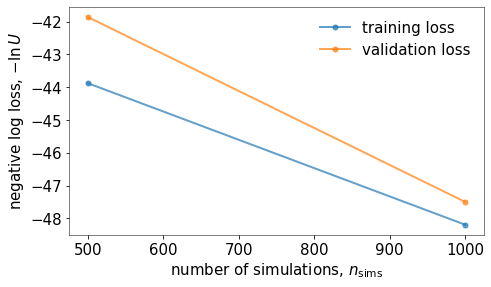

Population 2/15
Sampling proposal density...
Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


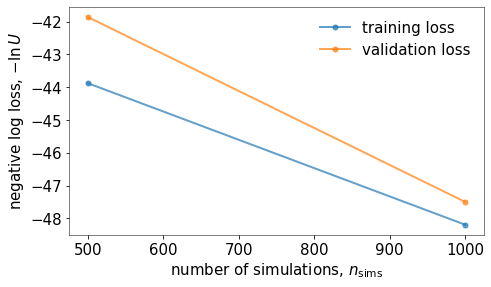

Population 3/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Simulator returns NaN/inf for parameter values: [ 1.23471170e+00  1.12734060e+01 -7.04271735e-02  4.08146782e+00
 -3.25369525e+00 -4.57477759e+00  3.36013711e+00 -1.21148668e+00
  1.02476026e-03 -4.26981875e-01] (rank 0)


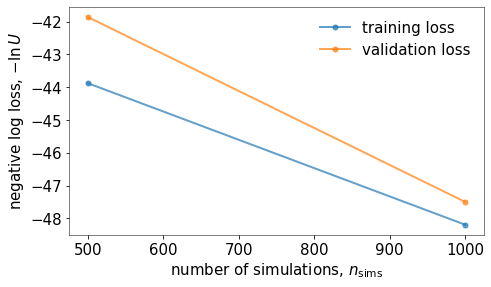

Population 4/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


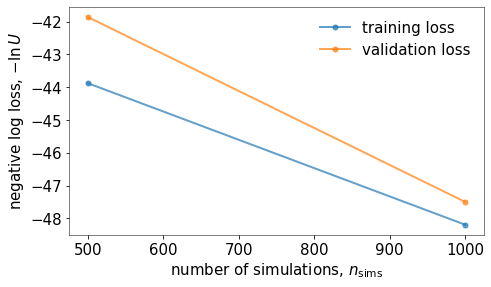

Population 5/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


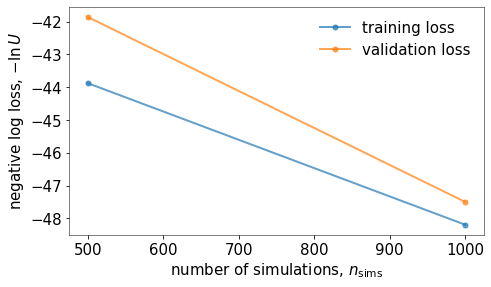

Population 6/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


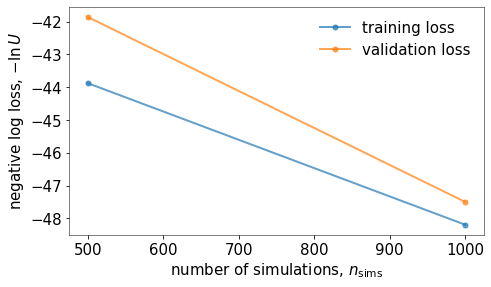

Population 7/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Simulator returns NaN/inf for parameter values: [ 2.08322614e+00  3.17023347e+00 -2.13627102e+00  5.61772675e+00
 -2.84095904e+00 -7.39022140e+00  8.70834970e+00  1.54751071e+00
  1.00526516e-03 -3.59498294e-01] (rank 0)


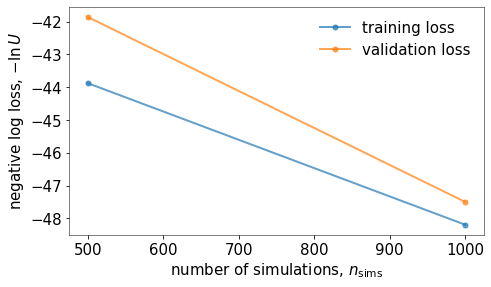

Population 8/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Simulator returns NaN/inf for parameter values: [ 1.23471170e+00  1.12734060e+01 -7.04271735e-02  4.08146782e+00
 -3.25369525e+00 -4.57477759e+00  3.36013711e+00 -1.21148668e+00
  1.02476026e-03 -4.26981875e-01] (rank 0)


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak


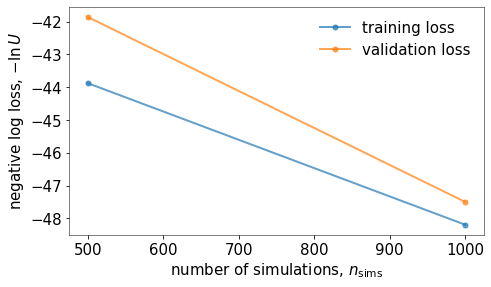

Population 9/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Simulator returns NaN/inf for parameter values: [-2.15895063e+00  1.72511232e+00 -4.68621368e+00  9.42098805e+00
  1.12782331e+00 -3.83551616e+00  4.84454057e+00 -2.27170297e+00
  1.17792014e-03 -5.06312293e-01] (rank 0)


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


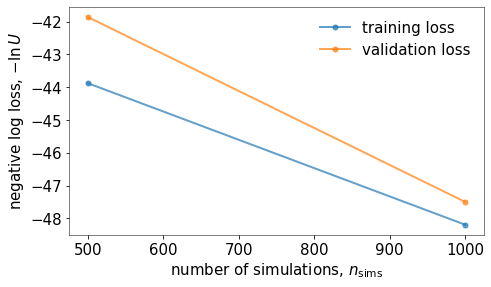

Population 10/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Simulator returns NaN/inf for parameter values: [-2.15895063e+00  1.72511232e+00 -4.68621368e+00  9.42098805e+00
  1.12782331e+00 -3.83551616e+00  4.84454057e+00 -2.27170297e+00
  1.17792014e-03 -5.06312293e-01] (rank 0)


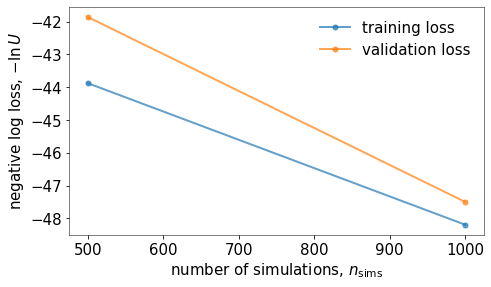

Population 11/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


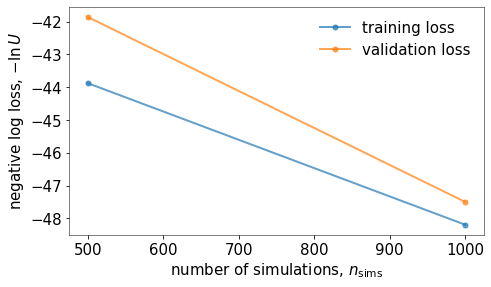

Population 12/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Simulator returns NaN/inf for parameter values: [ 1.23471170e+00  1.12734060e+01 -7.04271735e-02  4.08146782e+00
 -3.25369525e+00 -4.57477759e+00  3.36013711e+00 -1.21148668e+00
  1.02476026e-03 -4.26981875e-01] (rank 0)
Simulator returns NaN/inf for parameter values: [ 2.08322614e+00  3.17023347e+00 -2.13627102e+00  5.61772675e+00
 -2.84095904e+00 -7.39022140e+00  8.70834970e+00  1.54751071e+00
  1.00526516e-03 -3.59498294e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


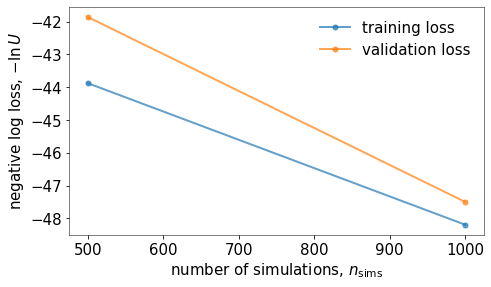

Population 13/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


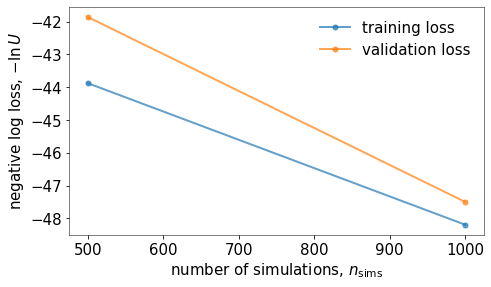

Population 14/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Simulator returns NaN/inf for parameter values: [-2.15895063e+00  1.72511232e+00 -4.68621368e+00  9.42098805e+00
  1.12782331e+00 -3.83551616e+00  4.84454057e+00 -2.27170297e+00
  1.17792014e-03 -5.06312293e-01] (rank 0)


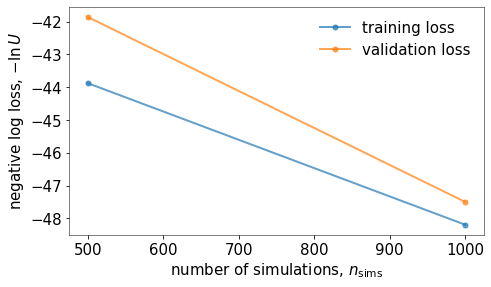

Population 15/15
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/simulator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  diff_peak_final = final - peak


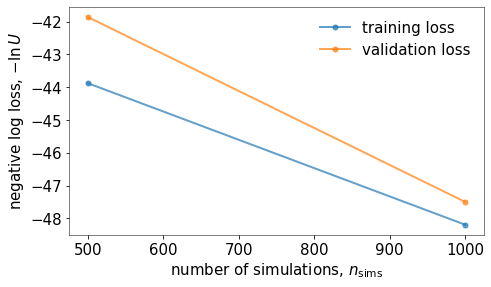

In [12]:
n_initial = 500
n_batch = 500
n_populations = 15

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=50., save_intermediate_posteriors=False, simulator_args = simulator_args, compressor_args = compressor_args)

## Sample the learned posterior

In [13]:
posterior_samples = DelfiEnsemble.emcee_sample()
np.save('pst_samples.npy', posterior_samples) # save

/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [14]:
def triangle_plot(samples = None, weights = None, savefig = False, filename = None):
        param_limits = [np.concatenate((np.array([2,  0, 2, 0, -12, -12, -12, -14]), [(-0.0011-(0.0011*0.8)**2),(-0.39-(0.39*1)**2)])), np.concatenate((np.array([18,  16, 18,  16, 0, 0, -2, 0]), [(2*0.0011+(0.0011*0.8)**2),(0.39+(0.39*0.8)**2)]))]
        lower = param_limits[0]
        upper = param_limits[1]
        param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']
        ranges = dict(zip(param_names, [ [lower[i], upper[i]] for i in range(len(param_names)) ]))
        
        # Set samples to the posterior samples by de fault
        if samples is None:
            samples = samples
        mc_samples = [MCSamples(samples=s, weights = None, names = param_names, labels = param_names, ranges = ranges) for s in samples]

        # Triangle plot
        with mpl.rc_context():
            g = plots.getSubplotPlotter(width_inch = 12)
            g.settings.figure_legend_frame = False
            g.settings.alpha_filled_add=0.6
            g.settings.axes_fontsize=10
            g.settings.legend_fontsize=10
            g.settings.lab_fontsize=15
            g.triangle_plot(mc_samples, filled_compare=True, normalized=True)
            for i in range(0, len(samples[0][0,:])):
                for j in range(0, i+1):
                    ax = g.subplots[i,j]
                    xtl = ax.get_xticklabels()
                    ax.set_xticklabels(xtl, rotation=45)
            plt.tight_layout()
            plt.subplots_adjust(hspace=0, wspace=0)

            if savefig:
                plt.savefig(filename)
                plt.show()
            else:
                plt.close()

Removed no burn in


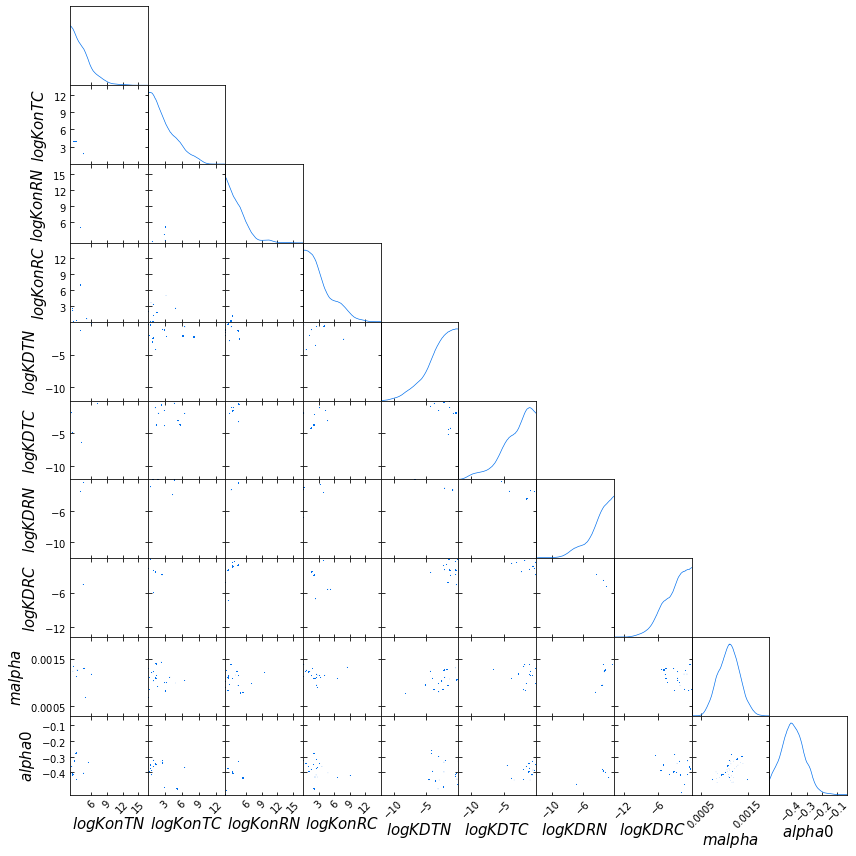

In [15]:

posterior_samples = np.load('pst_samples.npy')
#pst = np.unique(posterior_samples, axis=0)
#print(pst.shape)
#print(pst)
#print(posterior_samples.shape)
triangle_plot(samples=[posterior_samples], savefig=True, filename='plot.pdf')

# param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']
# from IPython.display import display, Math
# params_med = []
# params_up = []
# params_low = []
# for i in range(10):
#     mcmc = np.percentile(posterior_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], param_names[i])
#     params_low.append(mcmc[1] - q[0])
#     params_med.append(mcmc[1])
#     params_up.append(mcmc[1] + q[1])
#     print(txt)


# plt.show()
# print(params_med)

In [ ]:
posterior_samples = np.load('pst_samples.npy')
param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']
from IPython.display import display, Math
params_med = []
params_up = []
params_low = []
for i in range(10):
    mcmc = np.percentile(posterior_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], param_names[i])
    params_low.append(mcmc[1] - q[0])
    params_med.append(mcmc[1])
    params_up.append(mcmc[1] + q[1])
    print(txt)
    
print(params_med)

## Plot learned log-likelihood vs squared error (proportional to Gaussian Likelihood)


In [ ]:
# post = np.load('pst_samples_whole_comp_fisher.npy')
# post = np.unique(post, axis=0)
# eps = [0]*94
# ll = lambda x: np.sum(np.sum((faasSimulator.data() - faasSimulator.forward(np.concatenate((x,eps)), seed))**2))

# ll_post = lambda x: DelfiEnsemble.log_likelihood_stacked(x, DelfiEnsemble.data)[0]

# # # pt_ll = [ll(i) for i in post]
# pt_ll_post = [ll_post(i) for i in post]
# #print(post.shape)
x = np.loadtxt(open('def.csv', "rb"), delimiter=',').T

plt.scatter(x[0], x[1])
plt.plot(np.unique(x[0]), np.poly1d(np.polyfit(x[0], x[1], 1))(np.unique(x[0])), color='red')
plt.xlabel("NDE log likelihood")
plt.ylabel("Squared Error")
plt.tight_layout()
plt.savefig('postvssquared_500.pdf')
plt.show()